# Importing Necessary Packages

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt
import geopandas as gpd
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import griddata
from shapely.geometry import Polygon, Point

## Defining the Average SPI Index Calculation function for selected stations over given dutation and SPI-Type (Eg: SPI-1, SPI-2, ...)

In [68]:
def calculate_SPI(file_path, SPI_Type=1, start_month="May-2015", end_month="Jul-2022"):
    # function to compute SPI
    def compute_SPI(precipitation, shape, scale):
        cdf = gamma.cdf(precipitation, shape, loc=0, scale=scale)
        spi = norm.ppf(cdf)
        return spi
    
    # get rainfall data from csv
    df = pd.read_csv(file_path)
    months = df['Dates'].values
    rainfall_data = df.iloc[:, 1].values
    
    # applying moving average filter to rainfall data
    rainfall_data = np.convolve(rainfall_data, np.ones(SPI_Type)/SPI_Type, mode='valid')
    
    if SPI_Type > 12:
        error = "SPI Type should be less than or equal to 12"
        return error
    
    # preprocessing the rainfall data
    rainfall_data = rainfall_data[np.isfinite(rainfall_data)]
    rainfall_data[rainfall_data == 0] = 1e-15
    
    # computing gamma parameters
    shape, loc, scale = gamma.fit(rainfall_data, floc=0)
    
    spi_values = compute_SPI(rainfall_data, shape, scale)
    
    # getting index for the starting and ending months
    start_idx = np.where(months == start_month)[0][0]
    end_idx = np.where(months == end_month)[0][0]
    
    # ensuring index aligns with the moving average filter application
    filtered_months = months[(SPI_Type-1):] 
    spi_range = spi_values[start_idx - (SPI_Type-1): end_idx - (SPI_Type-1) + 1]
    filtered_months = filtered_months[start_idx - (SPI_Type-1): end_idx - (SPI_Type-1) + 1]
    
    # print(filtered_months)
    
    average_spi = np.mean(spi_range)
    
    # calculating drought frequency
    drought_threshold = 0
    mask = (spi_range < drought_threshold)
    curr = False
    drought_freq = 0
    for i in mask:
        if i:
            if not curr:
                drought_freq += 1
                curr = True
        else:
            curr = False
            
    # initialize variables to track the longest drought duration
    longest_drought = 0
    current_drought = 0
    longest_drought_start = 0
    current_drought_start = 0
    for i, is_drought in enumerate(mask):
        if is_drought:
            current_drought += 1
            if current_drought == 1:
                current_drought_start = i
            if current_drought > longest_drought:
                longest_drought = current_drought
                longest_drought_start = current_drought_start
        else:
            current_drought = 0
            
    longest_drought_period = (longest_drought_start, longest_drought_start + longest_drought)
    
    
    print(f'Average SPI value from {start_month} to {end_month}: {average_spi:.2f}')
    print(f'Longest drought duration: {longest_drought} months')
    
    # creating separate spi dataframe for the filtered range
    spi_df_filtered = pd.DataFrame({'Month': filtered_months, 'SPI': spi_range})
    spi_df_filtered['Sign'] = ['Positive' if spi > 0 else 'Negative' for spi in spi_df_filtered['SPI']]
    
    # plot the graph of SPI Values over months for the filtered range
    plt.figure(figsize=(10, 6))
    plt.fill_between(spi_df_filtered['Month'], spi_df_filtered['SPI'], where=(spi_df_filtered['Sign'] == 'Positive'), color='blue', alpha=0.3, label='Positive SPI')
    plt.fill_between(spi_df_filtered['Month'], spi_df_filtered['SPI'], where=(spi_df_filtered['Sign'] == 'Negative'), color='red', alpha=0.3, label='Negative SPI')
    
    # highlight the longest drought period
    if longest_drought > 0:
        plt.fill_between(spi_df_filtered['Month'][longest_drought_period[0]:longest_drought_period[1]+1],
                         spi_df_filtered['SPI'][longest_drought_period[0]:longest_drought_period[1]+1],
                         color='purple', alpha=0.5, label='Longest Drought')

    
    plt.plot(spi_df_filtered['Month'], spi_df_filtered['SPI'], color='black', label='SPI Line')
    plt.xlabel('Months')
    plt.ylabel('SPI Values')
    plt.title('SPI Over Time for Specified Period')
    plt.xticks(rotation=45)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return average_spi, drought_freq, spi_df_filtered

# User Input

In [69]:
# taking starting and ending months from user as input [Our data is from May-2015 to Jul-2022]

start_month = input("Enter starting month and year [eg: May-2016]: ")
end_month = input("Enter ending month and year [eg:Jul-2021]: ")
SPI_Type = int(input("Enter SPI-Type [Eg: 3]: "))

# defining lists to add values of regions we do calculate these
average_spi_values = []
drought_frequencies = []

# defining list of latitudes and longitudes to add for each region
latitudes = []
longitudes = []

Enter starting month and year [eg: May-2016]: Jan-2016
Enter ending month and year [eg:Jul-2021]: Dec-2021
Enter SPI-Type [Eg: 3]: 5


# Bahalpur

Average SPI value from Jan-2016 to Dec-2021: 0.13
Longest drought duration: 5 months


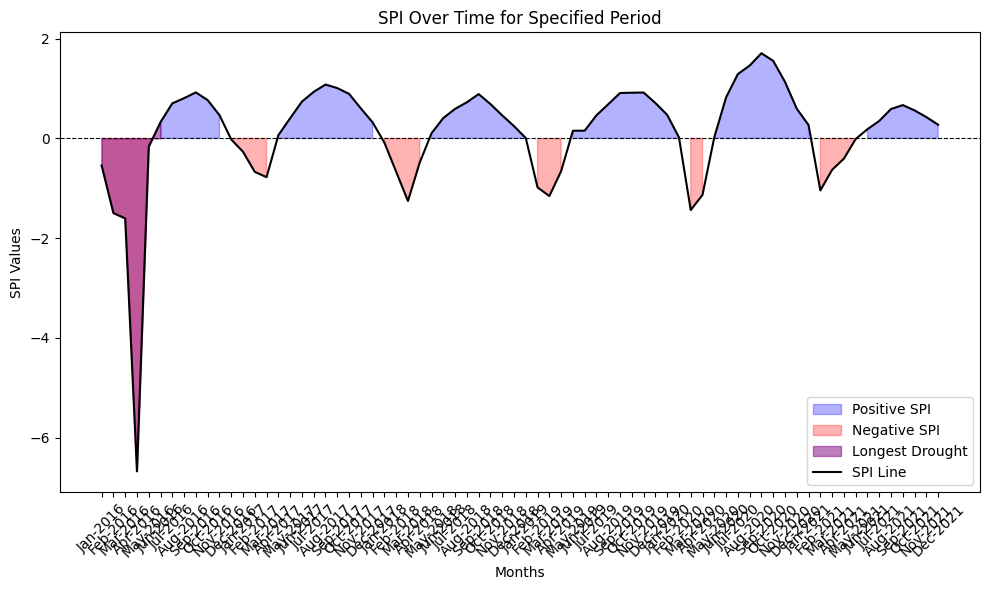

In [70]:
average_spi, drought_freq, spi_df = calculate_SPI('Bahalpur.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude,longitude = 26.3183, 90.4689
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Bhalukpong

Average SPI value from Jan-2016 to Dec-2021: 0.10
Longest drought duration: 20 months


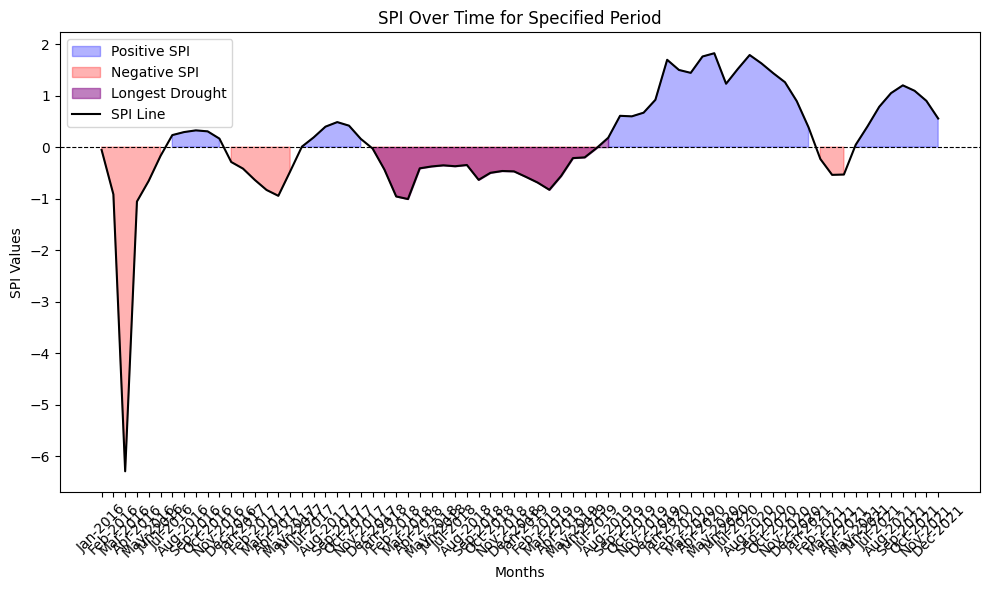

In [71]:
average_spi, drought_freq, spi_df = calculate_SPI('Bhalukpong.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 27.0144, 92.6497
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Bihubar

Average SPI value from Jan-2016 to Dec-2021: 0.15
Longest drought duration: 11 months


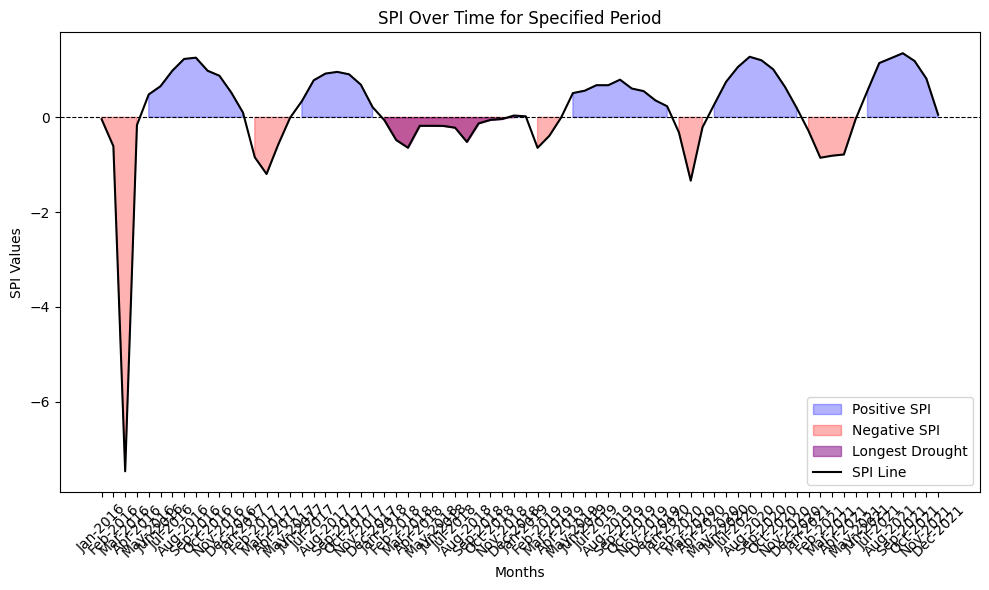

In [72]:
average_spi, drought_freq, spi_df = calculate_SPI('Bihubar.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.0167, 89.9903
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Bokajan

Average SPI value from Jan-2016 to Dec-2021: 0.13
Longest drought duration: 19 months


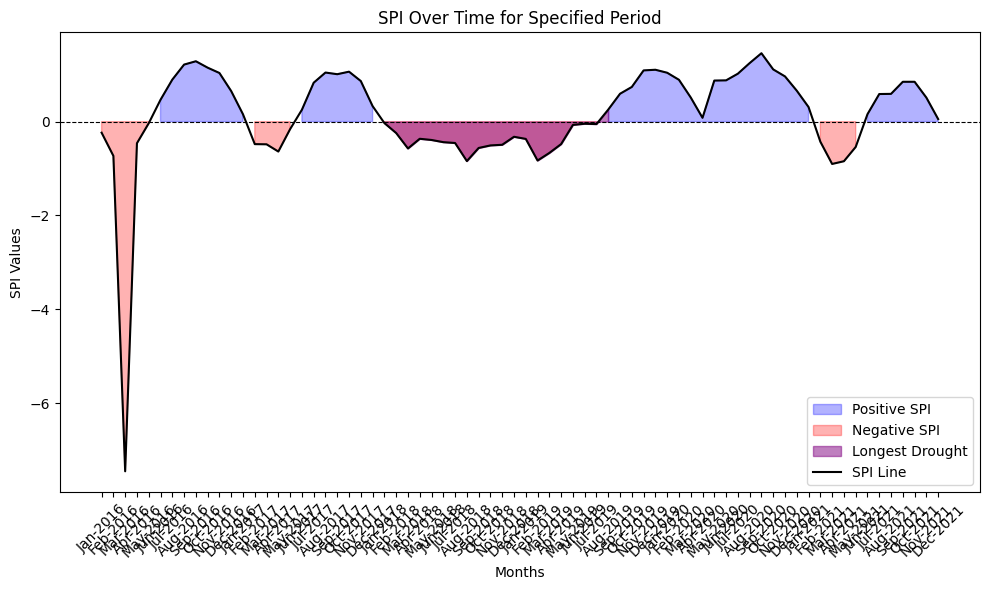

In [73]:
average_spi, drought_freq, spi_df = calculate_SPI('Bokajan.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.0161, 93.7872
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Chouldhowaghat

Average SPI value from Jan-2016 to Dec-2021: 0.02
Longest drought duration: 19 months


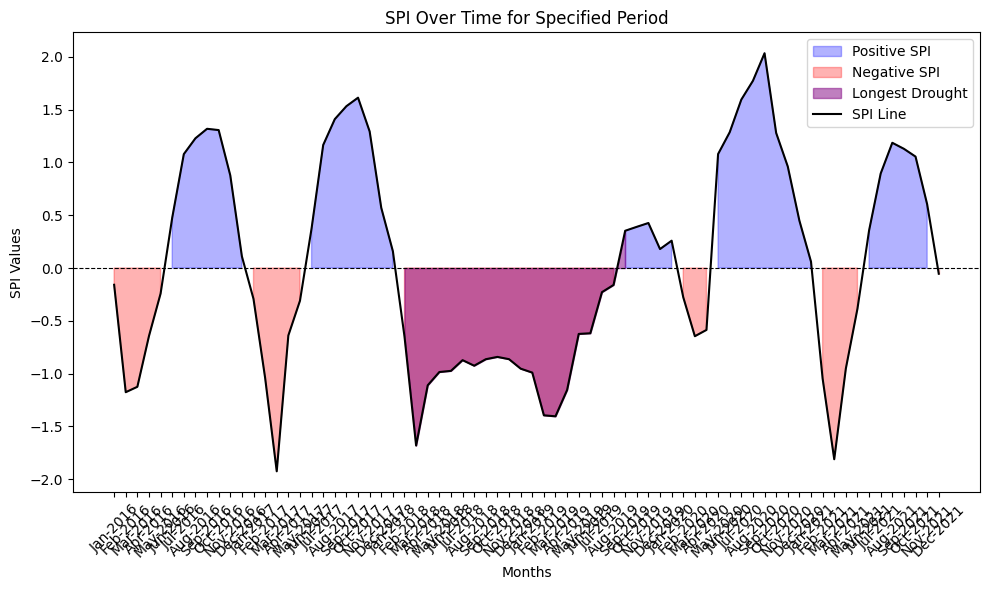

In [74]:
average_spi, drought_freq, spi_df = calculate_SPI('Chouldhowaghat.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 27.4475, 94.252
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Dharamtul

Average SPI value from Jan-2016 to Dec-2021: 0.10
Longest drought duration: 17 months


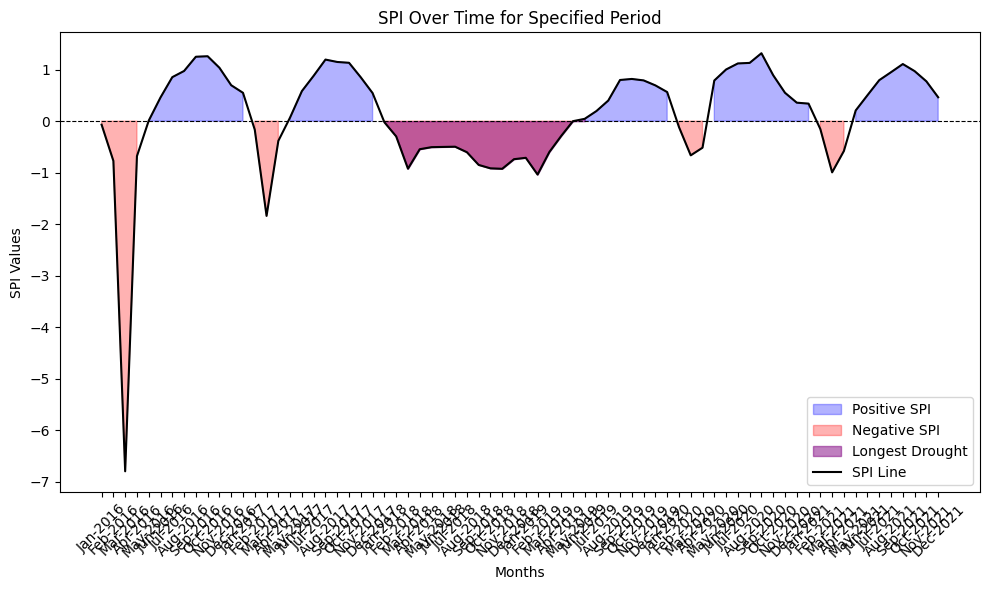

In [75]:
average_spi, drought_freq, spi_df = calculate_SPI('Dharamtul.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.1662, 92.3554
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Dhubri

Average SPI value from Jan-2016 to Dec-2021: 0.12
Longest drought duration: 5 months


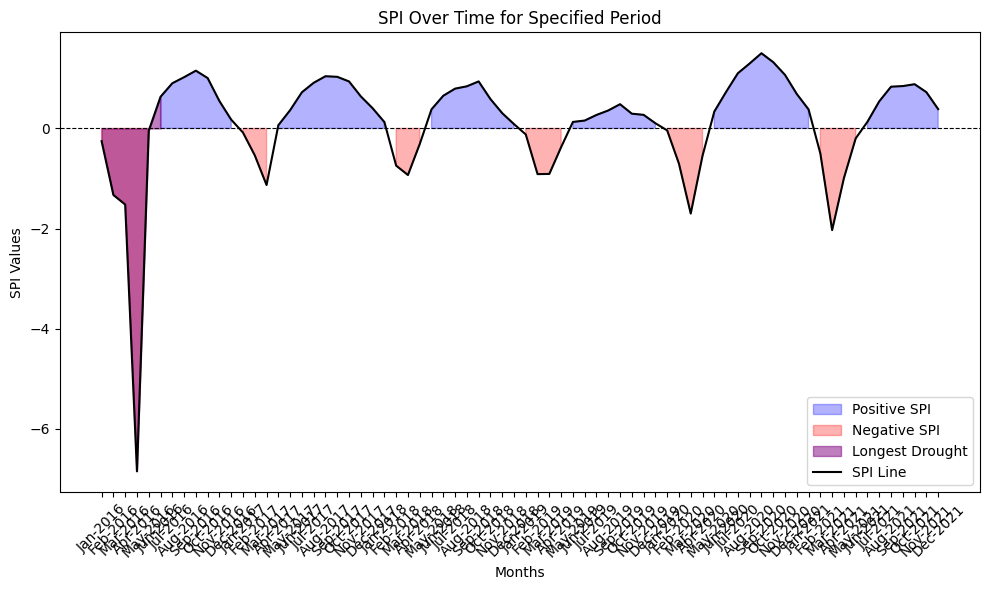

In [76]:
average_spi, drought_freq, spi_df = calculate_SPI('Dhubri.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.0167, 89.9903
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Dibrugarh

Average SPI value from Jan-2016 to Dec-2021: 0.10
Longest drought duration: 15 months


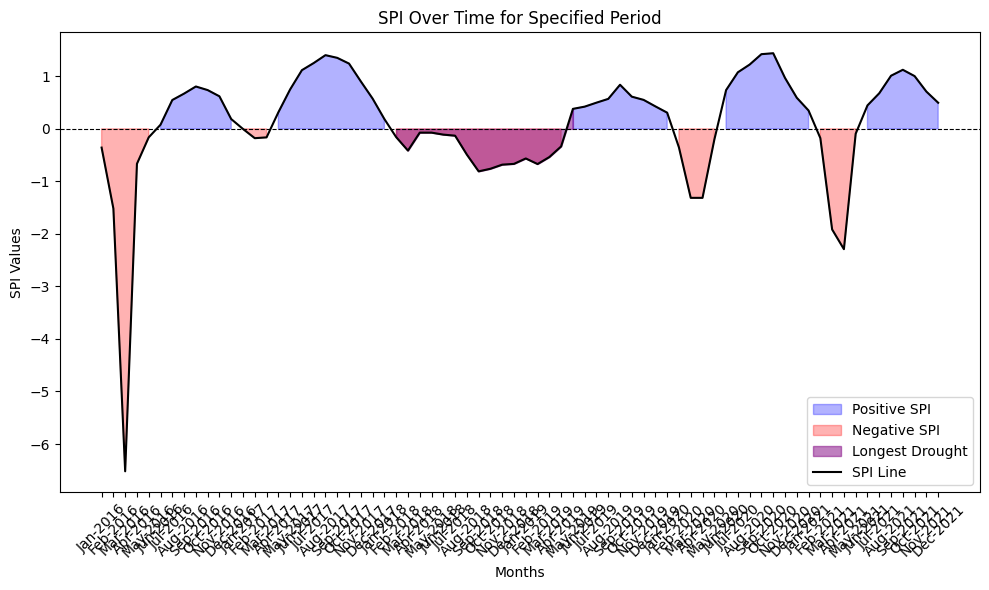

In [77]:
average_spi, drought_freq, spi_df = calculate_SPI('Dibrugarh.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 27.4989, 94.8558
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Domohani

Average SPI value from Jan-2016 to Dec-2021: 0.13
Longest drought duration: 6 months


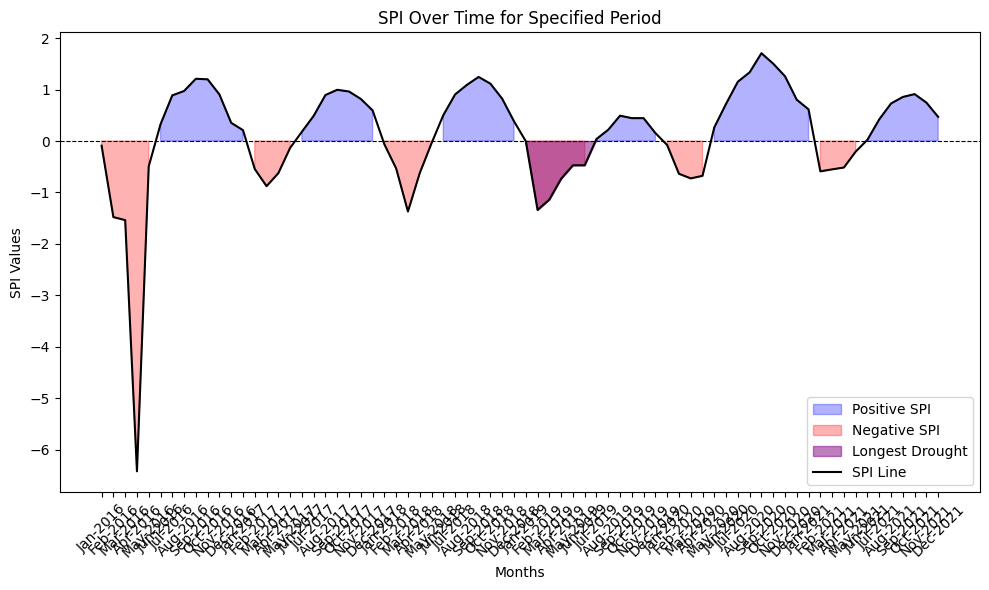

In [78]:
average_spi, drought_freq, spi_df = calculate_SPI('Domohani.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.5628, 88.7617
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# DRF

Average SPI value from Jan-2016 to Dec-2021: -0.03
Longest drought duration: 7 months


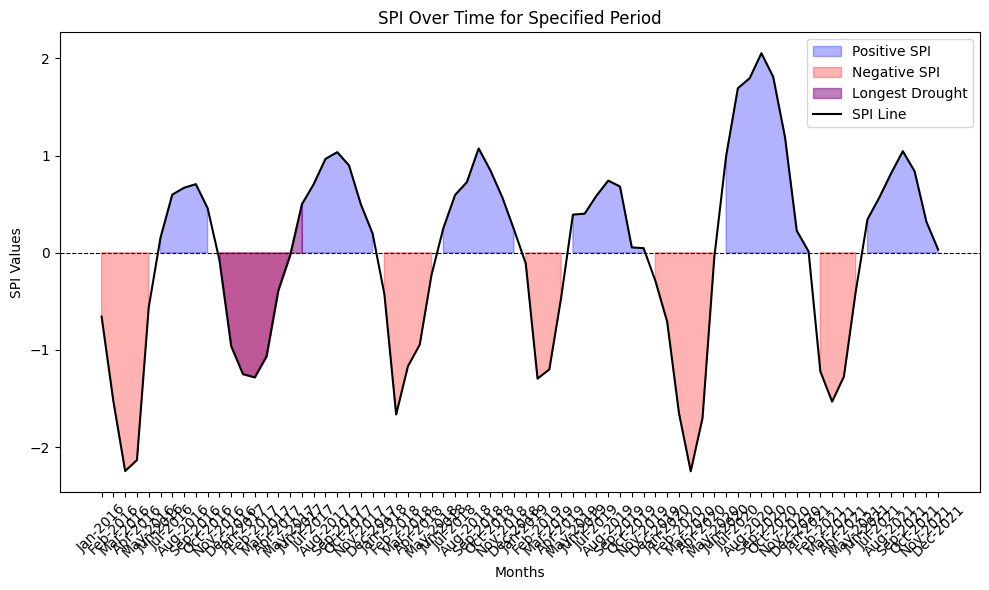

In [79]:
average_spi, drought_freq, spi_df = calculate_SPI('DRF.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.8000, 91.7000
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Hasimara

Average SPI value from Jan-2016 to Dec-2021: 0.11
Longest drought duration: 5 months


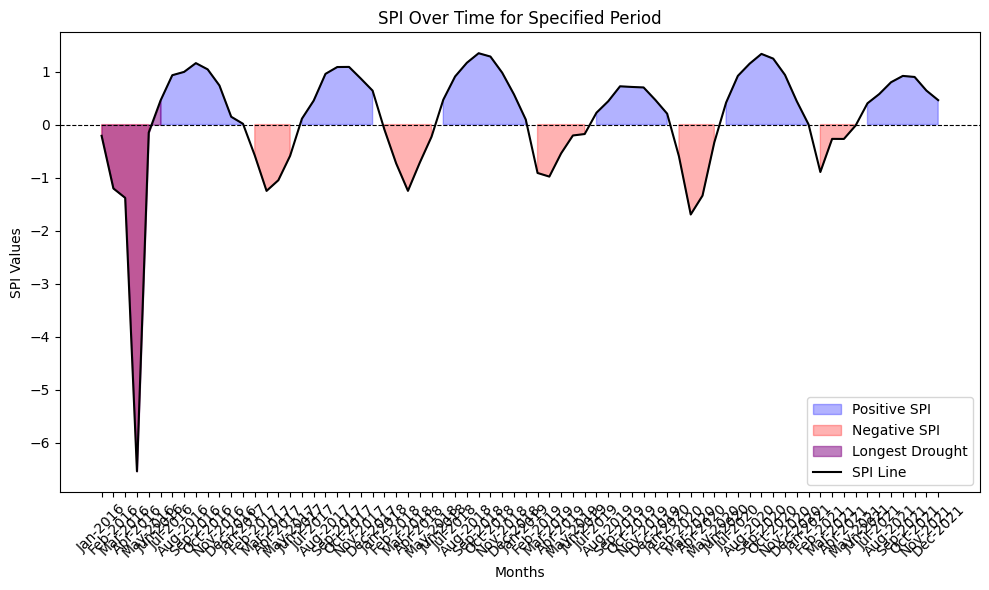

In [80]:
average_spi, drought_freq, spi_df = calculate_SPI('Hasimara.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.7292, 89.3272
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Kheronighat

Average SPI value from Jan-2016 to Dec-2021: 0.17
Longest drought duration: 18 months


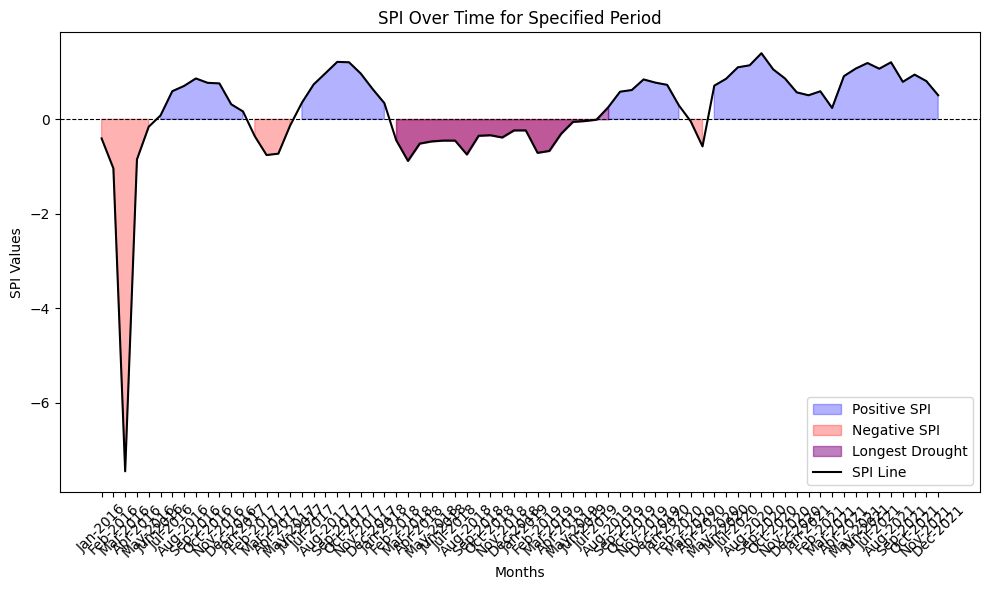

In [81]:
average_spi, drought_freq, spi_df = calculate_SPI('Kheronighat.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 25.8483, 92.8883
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Kibithu

Average SPI value from Jan-2016 to Dec-2021: 0.10
Longest drought duration: 7 months


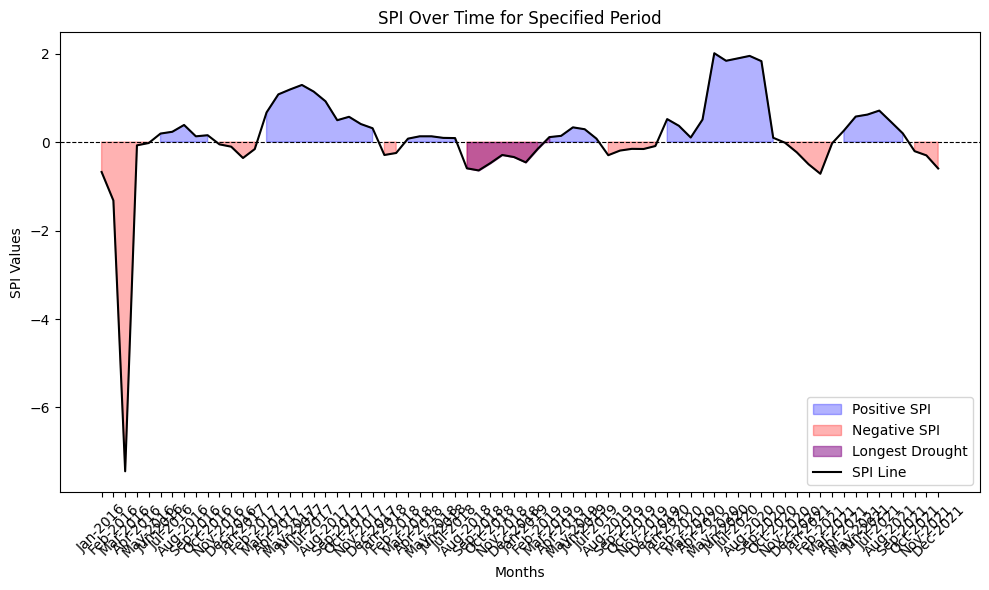

In [82]:
average_spi, drought_freq, spi_df = calculate_SPI('Kibithu.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 28.2572, 97.0258
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# ManasNHCrossing

Average SPI value from Jan-2016 to Dec-2021: 0.02
Longest drought duration: 7 months


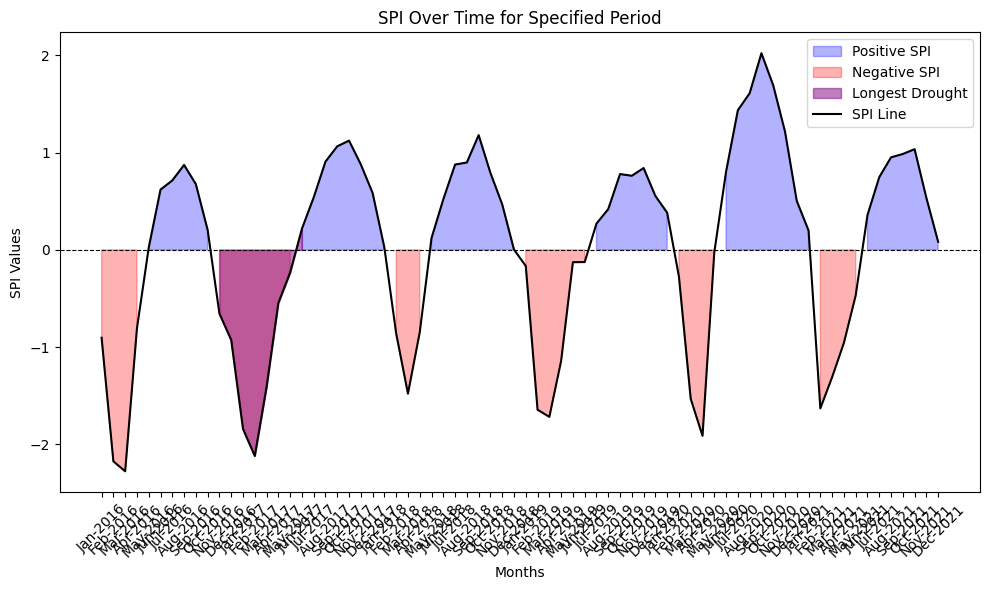

In [83]:
average_spi, drought_freq, spi_df = calculate_SPI('ManasNHCrossing.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.4642, 90.7489
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Miao

Average SPI value from Jan-2016 to Dec-2021: 0.03
Longest drought duration: 16 months


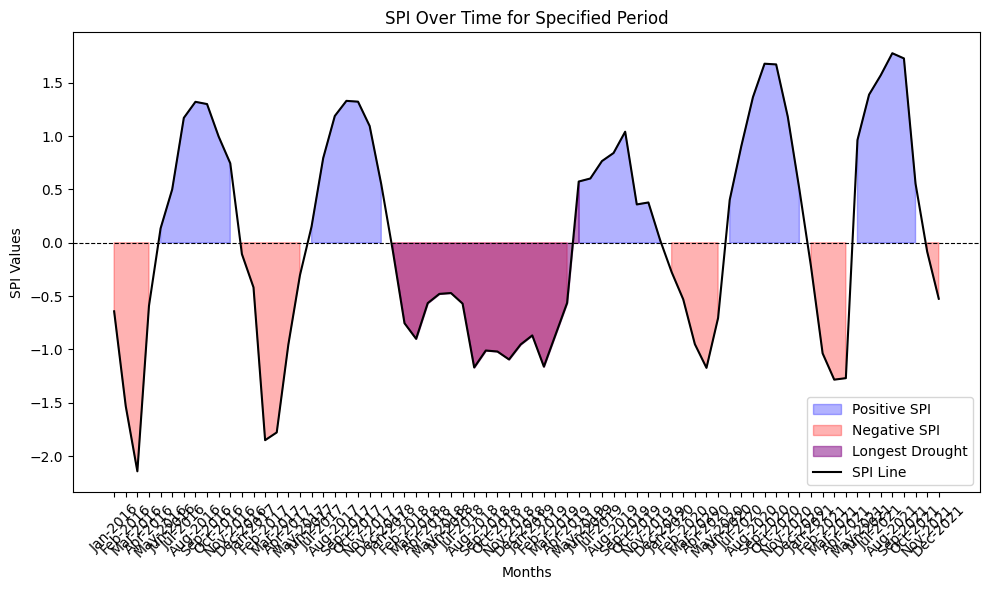

In [84]:
average_spi, drought_freq, spi_df = calculate_SPI('Miao.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 27.4869, 96.2094
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Nagarkata

Average SPI value from Jan-2016 to Dec-2021: 0.14
Longest drought duration: 5 months


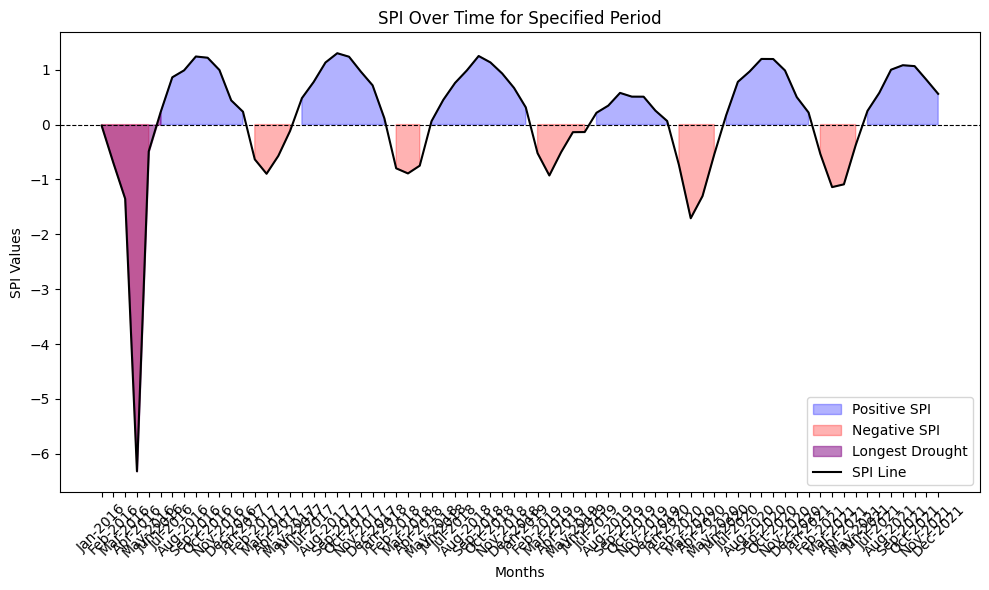

In [85]:
average_spi, drought_freq, spi_df = calculate_SPI('Nagarkata.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.8706, 88.8956
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Numaligarh

Average SPI value from Jan-2016 to Dec-2021: 0.13
Longest drought duration: 14 months


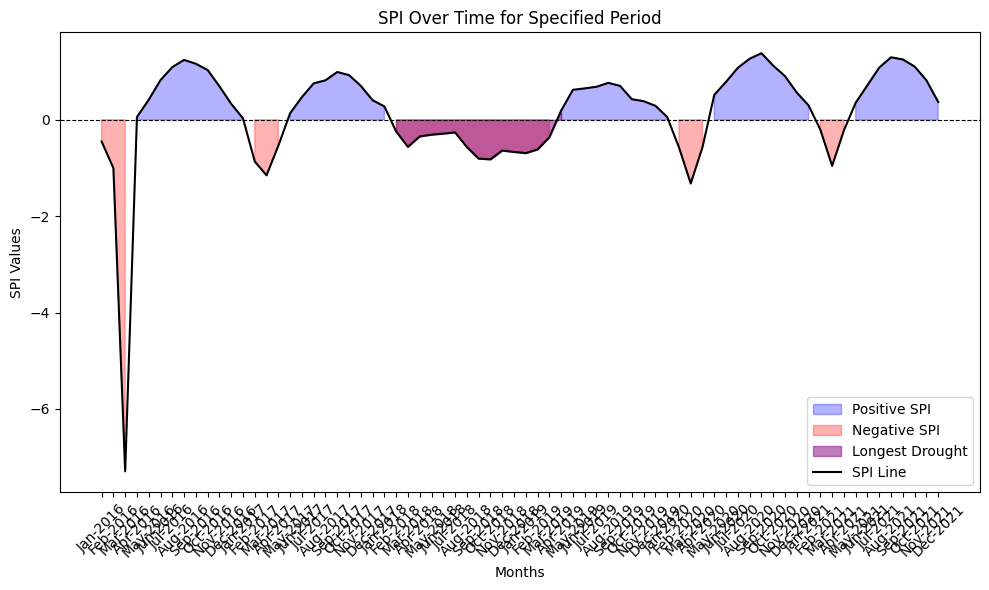

In [86]:
average_spi, drought_freq, spi_df = calculate_SPI('Numaligarh.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 26.6312, 93.7304
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Rimbi

Average SPI value from Jan-2016 to Dec-2021: 0.22
Longest drought duration: 12 months


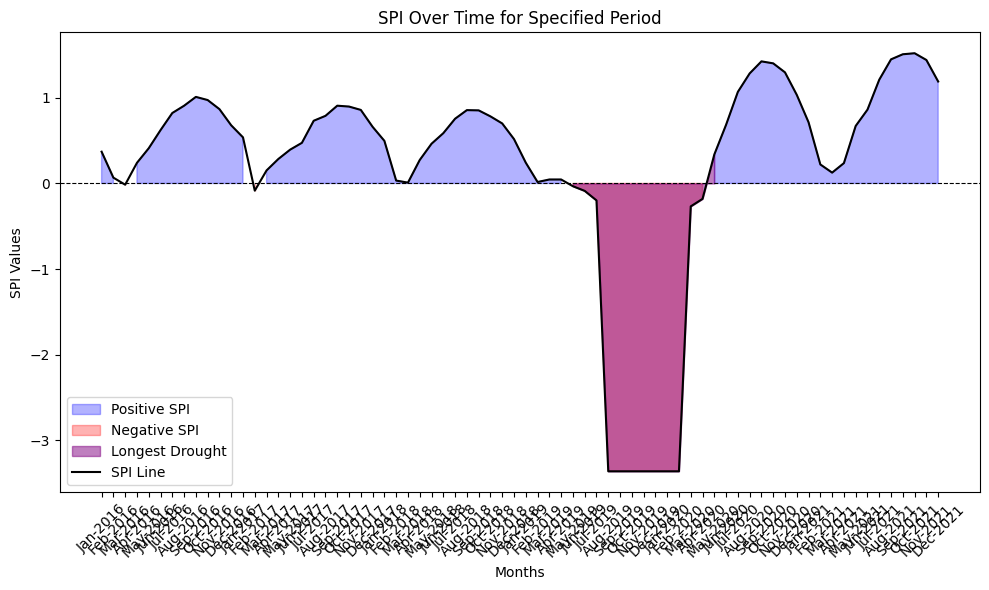

In [87]:
average_spi, drought_freq, spi_df = calculate_SPI('Rimbi.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 27.3149, 88.1876
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Sankalang

Average SPI value from Jan-2016 to Dec-2021: -0.05
Longest drought duration: 41 months


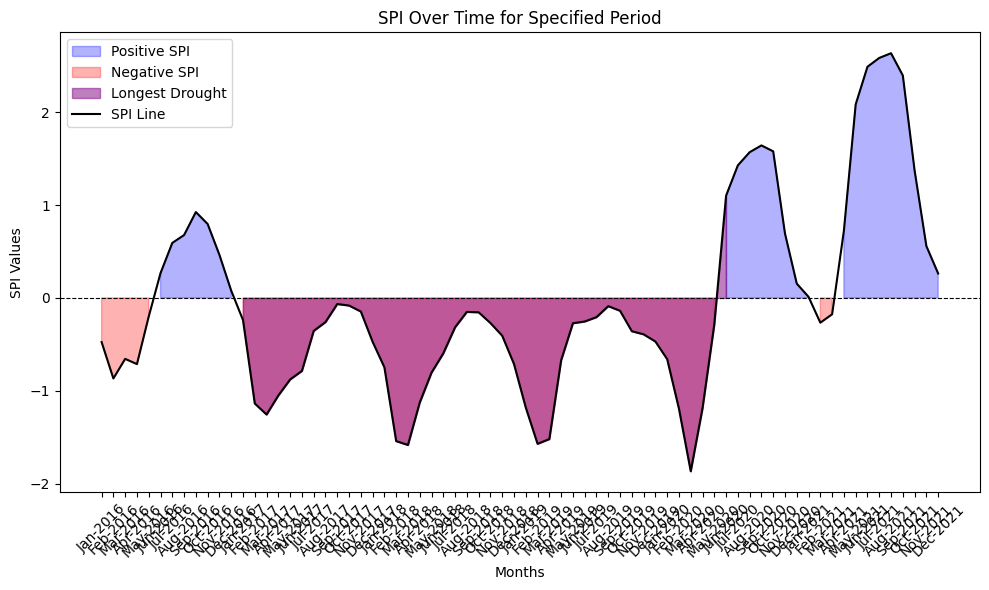

In [88]:
average_spi, drought_freq, spi_df = calculate_SPI('Sankalang.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 27.5123, 88.5289
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Tuting

Average SPI value from Jan-2016 to Dec-2021: 0.12
Longest drought duration: 9 months


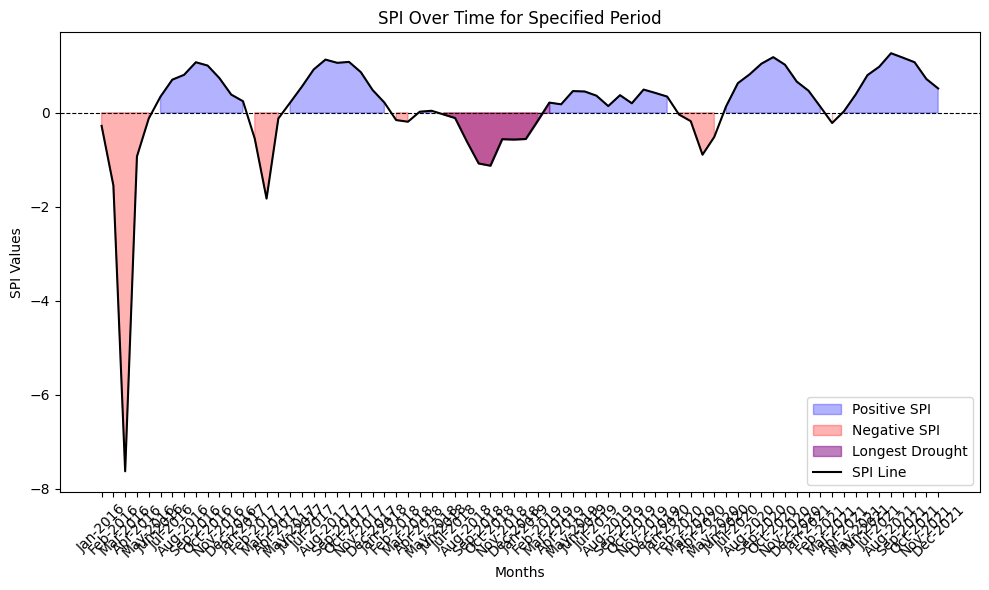

In [89]:
average_spi, drought_freq, spi_df = calculate_SPI('Tuting.csv', SPI_Type=SPI_Type, start_month=start_month, end_month=end_month)

latitude, longitude = 28.9906, 94.8950
average_spi_values.append(average_spi)
drought_frequencies.append(drought_freq)
latitudes.append(latitude)
longitudes.append(longitude)

# Showing the shapefile of Brahmaputra basin

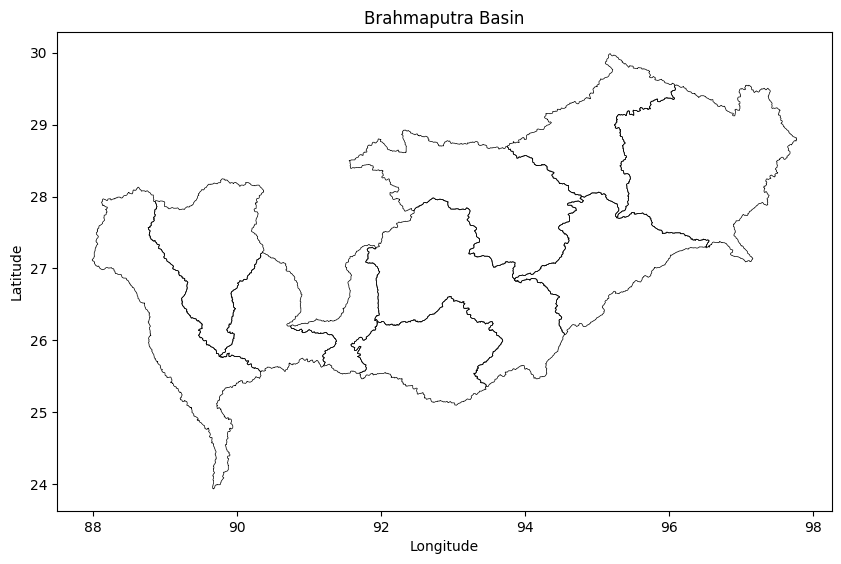

In [90]:
shapefile_path = './Shapefile/Brahmaputra.shp'
brahmaputra_basin = gpd.read_file(shapefile_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_facecolor('white')
brahmaputra_basin.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)
plt.title('Brahmaputra Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [91]:
lats = [26.3183, 27.0144, 26.0167, 26.0161, 27.4475, 26.1662, 26.0167, 27.4989, 26.5628, 26.8000, 26.7292, 25.8483, 28.2572, 26.4642, 27.4869, 26.8706, 26.6312, 27.3149, 27.5123, 28.9906]
longs = [90.4689, 92.6497, 89.9903, 93.7872, 94.252, 92.3554, 89.9903, 94.8558, 88.7617, 91.7000, 89.3272, 92.8883, 97.0258, 90.7489, 96.2094, 88.8956, 93.7304, 88.1876, 88.5289, 94.8950]

# Showing SPI Indexes of all 20 stations

In [92]:
average_spi_values

[0.12865570533591997,
 0.09500782685468614,
 0.14602296548671934,
 0.1333972861230721,
 0.017600417338330523,
 0.10349710122589223,
 0.11617201144238326,
 0.09686396738519355,
 0.13032569531452964,
 -0.03423038005130876,
 0.1089026949321708,
 0.17416964095997106,
 0.10328007617242758,
 0.019063020351024067,
 0.027703038156293477,
 0.1403841346237049,
 0.13391374974039558,
 0.2173294009653803,
 -0.05158039418310524,
 0.11794386717900493]

# Showing Drought Frequencies of all 20 stations

In [93]:
drought_frequencies = np.array(drought_frequencies, dtype=float)
print(drought_frequencies)

[6. 4. 6. 4. 6. 5. 6. 5. 6. 6. 6. 4. 7. 6. 6. 6. 5. 3. 3. 6.]


# Doing Spatial Interpolation of SPI using Nearest Method (handling all polygons)

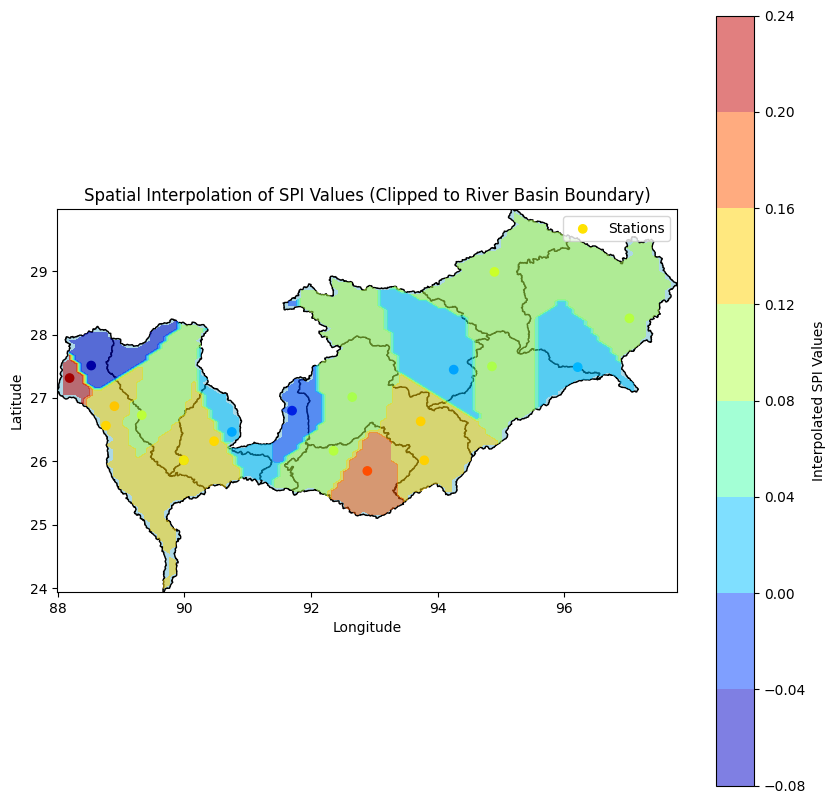

In [94]:
river_basin = gpd.read_file('Shapefile/Brahmaputra.shp')

station_data = {
    'Frequency': drought_frequencies,
    'SPI': average_spi_values,
    'Longitude': longs,
    'Latitude': lats,
}

# plot the river basin
fig, ax = plt.subplots(figsize=(10, 10))
river_basin.plot(ax=ax, color='lightblue', edgecolor='black')

# plot the stations
ax.scatter(station_data['Longitude'], station_data['Latitude'], c=station_data['SPI'], cmap='jet', label='Stations')

# define the grid over which to interpolate SPI values
x_grid = np.linspace(river_basin.bounds.minx.min(), river_basin.bounds.maxx.max(), 100)
y_grid = np.linspace(river_basin.bounds.miny.min(), river_basin.bounds.maxy.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# interpolate SPI values using griddata using nearest method
SPI_interpolated = griddata(
    (station_data['Longitude'], station_data['Latitude']), 
    station_data['SPI'], 
    (X, Y), 
    method='nearest'
)

# prepare a mask for the grid points
boundary_polygon = river_basin.geometry.unary_union  # Handling all polygons
mask = np.zeros(X.shape, dtype=bool)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = Point(X[i, j], Y[i, j])
        mask[i, j] = boundary_polygon.contains(point)

# apply the mask - SPI values are now only within the river basin's boundaries
clipped_SPI = np.where(mask, SPI_interpolated, np.nan)

# plot the clipped interpolated SPI values as a contour plot
contour = plt.contourf(X, Y, clipped_SPI, cmap='jet', alpha=0.5)
plt.colorbar(contour, ax=ax, label='Interpolated SPI Values')

plt.title('Spatial Interpolation of SPI Values (Clipped to River Basin Boundary)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [95]:
# # load the river basin shapefile
# river_basin = gpd.read_file('Shapefile/Brahmaputra.shp')

# station_data = {
#     'Frequency': drought_frequencies,
#     'SPI': average_spi_values,
#     'Longitude': longs,
#     'Latitude': lats,
# }

# # plot the river basin
# fig, ax = plt.subplots(figsize=(10, 10))
# river_basin.plot(ax=ax, color='lightblue', edgecolor='black')

# # plot the stations
# ax.scatter(station_data['Longitude'], station_data['Latitude'], c=station_data['SPI'], cmap='jet', label='Stations')

# # define the grid over which to interpolate SPI values
# x_grid = np.linspace(river_basin.bounds.minx.min(), river_basin.bounds.maxx.max(), 100)
# y_grid = np.linspace(river_basin.bounds.miny.min(), river_basin.bounds.maxy.max(), 100)
# X, Y = np.meshgrid(x_grid, y_grid)

# # interpolate SPI values using griddata with cubic interpolation
# SPI_interpolated = griddata(
#     (station_data['Longitude'], station_data['Latitude']), 
#     station_data['SPI'], 
#     (X, Y), 
#     method='cubic'
# )

# # prepare a mask for the grid points
# boundary_polygon = river_basin.geometry.unary_union  # handling all polygons
# mask = np.zeros(X.shape, dtype=bool)

# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         point = Point(X[i, j], Y[i, j])
#         mask[i, j] = boundary_polygon.contains(point)

# # apply the mask - SPI values are now only within the river basin's boundaries
# clipped_SPI = np.where(mask, SPI_interpolated, np.nan)

# # plot the clipped interpolated SPI values as a contour plot
# contour = plt.contourf(X, Y, clipped_SPI, cmap='jet', alpha=0.5)
# plt.colorbar(contour, ax=ax, label='Interpolated SPI Values')

# plt.title('Spatial Interpolation of SPI Values (Clipped to River Basin Boundary)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend()
# plt.show()


# Doing Spatial Interpolation of Frequency using Nearest Method (handling all polygons)

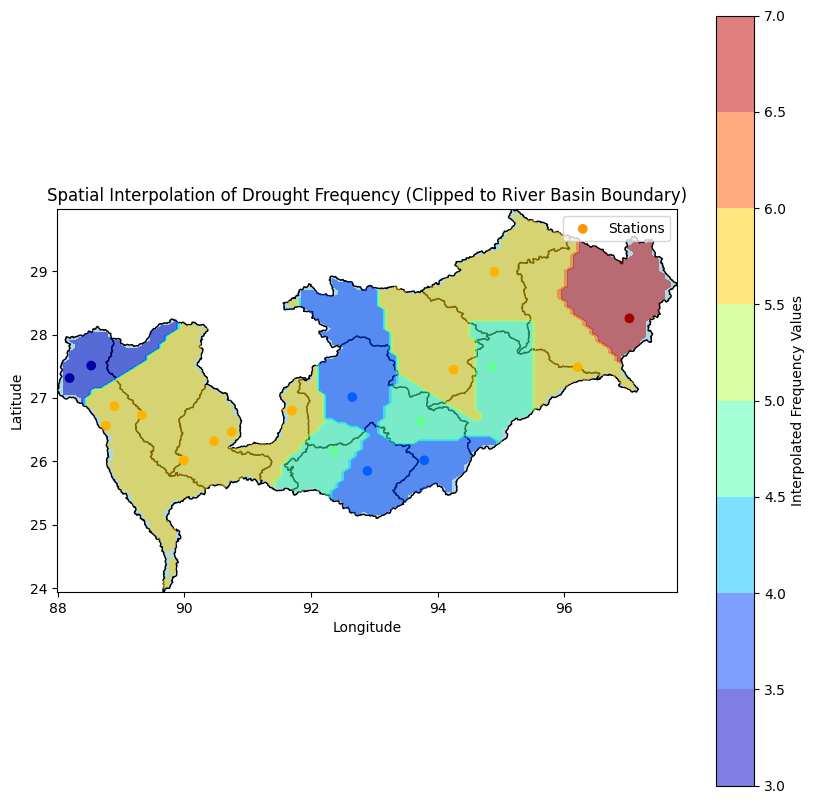

In [96]:
# load the river basin shapefile
river_basin = gpd.read_file('Shapefile/Brahmaputra.shp')

station_data = {
    'Frequency': drought_frequencies,
    'SPI': average_spi_values,
    'Longitude': longs,
    'Latitude': lats,
}

# define the grid over which to interpolate values
x_grid = np.linspace(river_basin.bounds.minx.min(), river_basin.bounds.maxx.max(), 100)
y_grid = np.linspace(river_basin.bounds.miny.min(), river_basin.bounds.maxy.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)

# prepare a mask for the grid points
boundary_polygon = river_basin.geometry.unary_union  # handling all polygons
mask = np.zeros(X.shape, dtype=bool)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = Point(X[i, j], Y[i, j])
        mask[i, j] = boundary_polygon.contains(point)

# plot the river basin
fig, ax = plt.subplots(figsize=(10, 10))
river_basin.plot(ax=ax, color='lightblue', edgecolor='black')

# plot the stations
ax.scatter(station_data['Longitude'], station_data['Latitude'], c=station_data['Frequency'], cmap='jet', label='Stations')

# interpolate Frequency values using griddata
Frequency_interpolated = griddata(
    (station_data['Longitude'], station_data['Latitude']), 
    station_data['Frequency'], 
    (X, Y), 
    method='nearest'
)

# apply the mask - Frequency values are now only within the river basin's boundaries
clipped_Frequency = np.where(mask, Frequency_interpolated, np.nan)

# plot the clipped interpolated Frequency values as a contour plot
contour = plt.contourf(X, Y, clipped_Frequency, cmap='jet', alpha=0.5)
plt.colorbar(contour, ax=ax, label='Interpolated Frequency Values')

plt.title('Spatial Interpolation of Drought Frequency (Clipped to River Basin Boundary)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


# Calculating the Areal Extent Percentage

In [97]:
cnt = 0
dro = 0
for i in range(clipped_SPI.shape[0]):
    for j in range(clipped_SPI.shape[1]):
        if (np.isnan(clipped_SPI[i][j])) == False:
            cnt += 1
            if(clipped_SPI[i][j] < 0):
                dro += 1
# print(dro)
# print(cnt)
print("Percentage of areal extent of drought: ", (dro/cnt)*100)

Percentage of areal extent of drought:  6.778330280031406


#### Specific Areal Extent Percentage Values I got for '2016', '2017', '2018', '2019', '2020', '2021' are 59.95812614498822, 10.730175346767862, 19.863909971211726, 4.7893221669719965, 3.0358544883538343, 0.0 respectively.

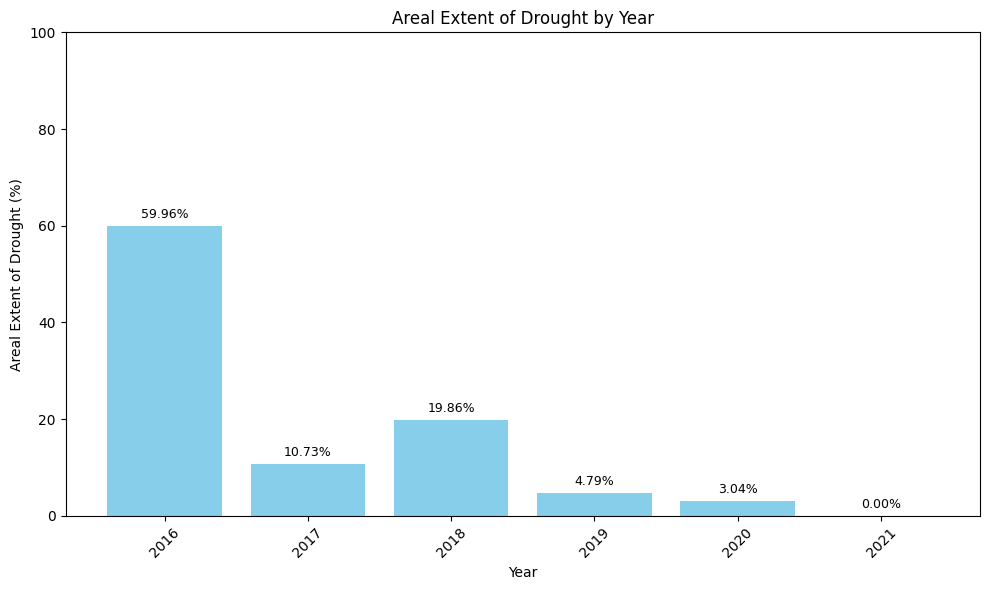

In [98]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
areal_extent = [59.95812614498822, 10.730175346767862, 19.863909971211726, 4.7893221669719965, 3.0358544883538343, 0.0]

plt.figure(figsize=(10, 6))
plt.bar(years, areal_extent, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Areal Extent of Drought (%)')
plt.title('Areal Extent of Drought by Year')
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100
for i, val in enumerate(areal_extent):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=9)  # Add text labels
plt.tight_layout()
plt.show()

# SPI Visualization in the raster file

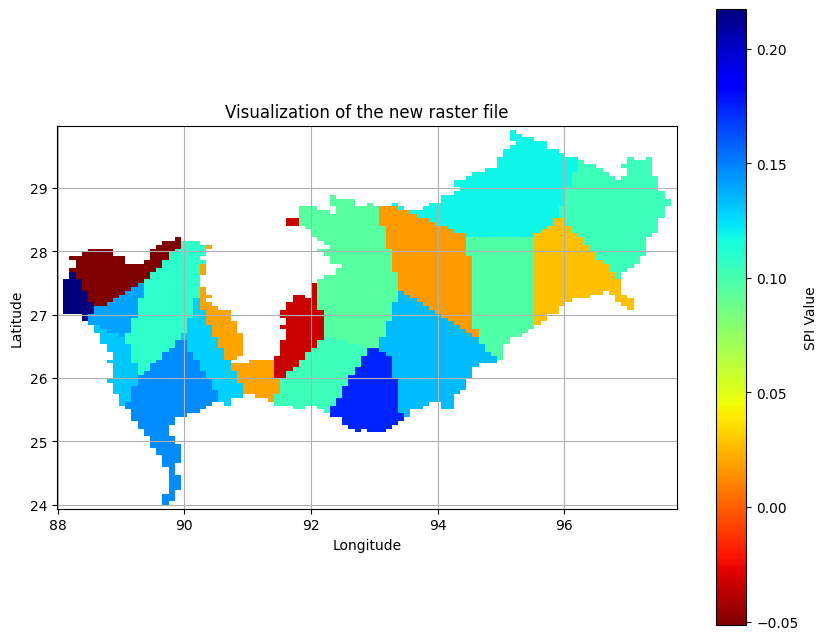

In [99]:
import rasterio
from rasterio.transform import from_origin

mask = np.isnan(clipped_SPI)

raster_df = pd.DataFrame({
    'X': X.flatten(),
    'Y': Y.flatten(),
    'SPI': clipped_SPI.flatten(),
    'Mask': mask.flatten()
})

raster_df = raster_df.dropna(subset=['SPI'])
raster_df = raster_df.reset_index(drop=True)

output_tif = 'clipped_SPI.tif'

nrows, ncols = clipped_SPI.shape

resolution = 1.0 
left, bottom, right, top = X.min(), Y.min(), X.max(), Y.max()

transform = from_origin(left, top, resolution, resolution)

meta = {
    'driver': 'GTiff',
    'dtype': raster_df['SPI'].dtype,
    'width': ncols,
    'height': nrows,
    'count': 1,
    'crs': 'EPSG:4326',
    'transform': transform,
    'nodata': np.nan
}

with rasterio.open(output_tif, 'w', **meta) as dst:
    dst.write(clipped_SPI, 1)

with rasterio.open(output_tif) as src:
    plt.figure(figsize=(10, 8))
    plt.imshow(clipped_SPI, cmap='jet_r', extent=(left, right, bottom, top), origin='lower')
    plt.colorbar(label='SPI Value')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Visualization of the new raster file')
    plt.grid(True)
    plt.show()

# Drought Frequency Visualization in the raster file

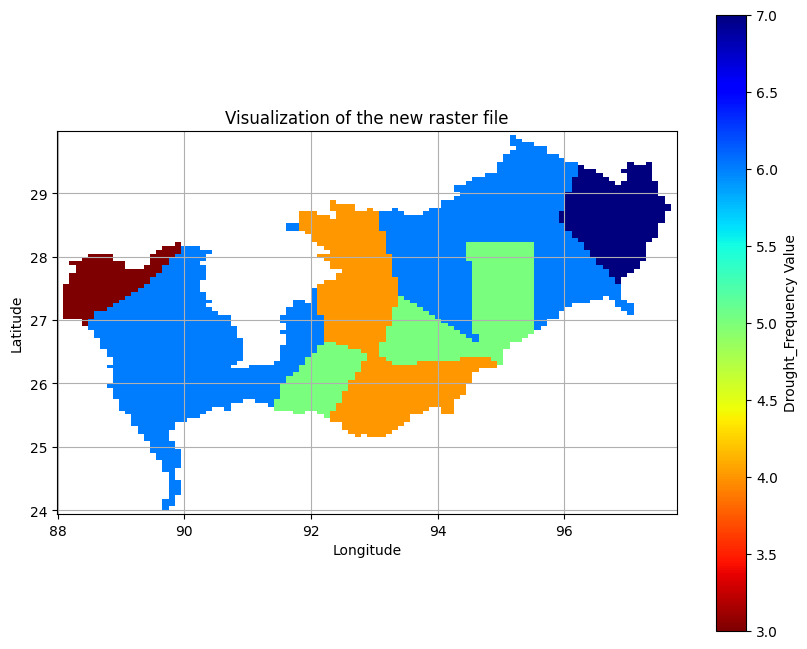

In [101]:
import rasterio
from rasterio.transform import from_origin

mask = np.isnan(clipped_Frequency)

raster_df = pd.DataFrame({
    'X': X.flatten(),
    'Y': Y.flatten(),
    'SPI': clipped_Frequency.flatten(),
    'Mask': mask.flatten()
})

raster_df = raster_df.dropna(subset=['SPI'])
raster_df = raster_df.reset_index(drop=True)

output_tif = 'clipped_Frequency.tif'

nrows, ncols = clipped_Frequency.shape

resolution = 1.0 
left, bottom, right, top = X.min(), Y.min(), X.max(), Y.max()

transform = from_origin(left, top, resolution, resolution)

meta = {
    'driver': 'GTiff',
    'dtype': raster_df['SPI'].dtype,
    'width': ncols,
    'height': nrows,
    'count': 1,
    'crs': 'EPSG:4326',
    'transform': transform,
    'nodata': np.nan
}

with rasterio.open(output_tif, 'w', **meta) as dst:
    dst.write(clipped_Frequency, 1)

with rasterio.open(output_tif) as src:
    plt.figure(figsize=(10, 8))
    plt.imshow(clipped_Frequency, cmap='jet_r', extent=(left, right, bottom, top), origin='lower')
    plt.colorbar(label='Drought_Frequency Value')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Visualization of the new raster file')
    plt.grid(True)
    plt.show()